## Analyzing Pcal Power Sensor Calibration Data

Importing modules.

In [396]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import datetime
from collections import defaultdict
import os

Creating lists of NIST-calibrated Gold Standard values, dates, and error, obtained from reports in the DCC.

In [397]:
NIST = [3.19910, 3.3418, -1.6935,-1.7067,-1.6969,-1.7140]
NIST_dates = [datetime.datetime(2007,9,20), datetime.datetime(2010,3,16), datetime.datetime(2014,8,12),datetime.datetime(2015,12,17),datetime.datetime(2017,1,23),datetime.datetime(2018,2,28)]
NIST_error = [0.095, 0.035, 0.065, 0.0481, 0.053, 0.0675]

The WS1/WSH to GS values are obtained from the trend data in the pcal svn. The data requires some light parsing to get into dates and values. The values are stored in a dictionary of dates and a dictionary of calibration factors, with keys corresponding to the measurement devices (ex:'WS_GS').

Due to the many changes the Hanford Working Standard has gone through, the data sets are split into distinct groups for the purpose of future scaling. These are "WS1_GS_pd1" (for the initial photodiode), "WS1_GS" (for the replacement photodiode), and "WSH_GS" (for the WS3 replacement of the damaged WS1).

In addition, early in the calibration processes, WS1_GS_pd1 was labeled WS_GS. These values have been added to WS1_GS_pd1.

In [398]:
calibration_vals = np.genfromtxt('pcalPowercalRatios.m', dtype = float, usecols = 1)
calibration_ids = np.genfromtxt('pcalPowercalRatios.m', dtype = str, usecols = 0)
#example id: PCAL_D20140815T1634_RAT_WS_GS

#create dictionaries
pwr_vals = defaultdict(list)
pwr_dates = defaultdict(list)
for idx, val in enumerate(calibration_ids):
    #pull date values out of id
    date = datetime.datetime(int(val[6:10]), int(val[10:12]), int(val[12:14]), int(val[15:17]), int(val[17:19]))
    #add WS_GS to WS1_GS_pd1
    if val[24:] == 'WS_GS':
        pwr_dates['WS1_GS_pd1'].append(date)
        pwr_vals['WS1_GS_pd1'].append(calibration_vals[idx])
    #separate WS1_GS_pd1 from WS1_GS
    if val[24:] == 'WS1_GS' and date < datetime.datetime(2015, 2, 12, 15):
        pwr_dates['WS1_GS_pd1'].append(date)
        pwr_vals['WS1_GS_pd1'].append(calibration_vals[idx])
    else:
        pwr_dates[val[24:]].append(date)
        pwr_vals[val[24:]].append(calibration_vals[idx])
        
#example output
print ('DATE:', pwr_dates['WSH_GS'][0], ' CALIBRATION FACTOR:', pwr_vals['WSH_GS'][0])

DATE: 2016-11-01 15:25:00  CALIBRATION FACTOR: 0.8341759


Data from 2008-2013 is retrieved from 'GS_WS-ALL' in the svn, and the dataset is labeled 'WS_GS'. Dates are given in GPS time and are converted into datetime objects.

In [399]:
WS_GS_dates = []
#extract GPS times and calibration factors
gps_dates = np.genfromtxt('../../../pcal_svn/PhotonCalibrator/measurements/LabData_2012-2013/GS_WS-ALL/data.txt', usecols=0)
WS_GS_vals = np.genfromtxt('../../../pcal_svn/PhotonCalibrator/measurements/LabData_2012-2013/GS_WS-ALL/data.txt', usecols=2)
#convert GPS time to datetime objects
for idx, val in enumerate(gps_dates):
    new_date = datetime.datetime(1980,1,6)+datetime.timedelta(seconds=val-(35-19))
    WS_GS_dates.append(new_date)
    
#example output
print ('DATE:', WS_GS_dates[0], ' CALIBRATION FACTOR:', WS_GS_vals[0])

DATE: 2007-10-09 11:59:58  CALIBRATION FACTOR: 0.998497888


Data from several recent measurements is added. The first list is a set of WSH_GS calibrations, initially taken to inspect the spread of calibrations measurements taken over a short timespan. They instead revealed a ~0.5% offset in WSH_GS new values, indicating some issue with one of the standards.

The second set of data is WSL/GS measurements taken after the offset WSH/GS measurements to verify that the gold standard is not the source of error.

The third set of data checked for temperature dependence in the beam splitter by taking a 60 minute integration right after exposing the beam splitter to the laser. Dividing one side by the other would theoretically remove laser variations, leaving changes in the BS.

The fourth set of data involved mountless WSH/GS measurements that vary the angle of incidence and distance from beam splitter. This was to determine if the back of the integrating sphere was experiencing degradation of its lining.

In [400]:
WSH_GS_check = [0.8268487, 0.8240138, 0.8246583, 0.8233268, 0.8252861, 0.8242799, 0.8246197, 0.8252857, 0.8236029, 0.8246453, 0.8261193, 0.8254199, 0.82436, 0.8251545, 0.8257822, 0.8248106]
#copy for second section analysis
WSH_GS_check1 = [0.8268487, 0.8240138, 0.8246583, 0.8233268, 0.8252861, 0.8242799, 0.8246197, 0.8252857, 0.8236029, 0.8246453, 0.8261193, 0.8254199, 0.82436, 0.8251545, 0.8257822, 0.8248106]
#establishing measurement dates
WSH_GS_check_dates = []
for i in range(4):
    WSH_GS_check_dates.append(datetime.date(2018,3,22))
for i in range(8):
    WSH_GS_check_dates.append(datetime.date(2018,3,23))
for i in range(4):
    WSH_GS_check_dates.append(datetime.date(2018,4,12))

WSL_GS_check = [0.8882029, 0.887259, 0.8895526, 0.8873081]
#establishing measurement dates
WSL_GS_check_dates = []
for i in range(len(WSL_GS_check)):
    WSL_GS_check_dates.append(datetime.date(2018,4,11))

GSrefl_tempcheck = np.genfromtxt('2018-04-11T1202_meas_GSRefl.csv', skip_header=1,delimiter=',', usecols = 1)
WStrans_tempcheck = np.genfromtxt('2018-04-11T1202_meas_WSHTran.csv', skip_header=1,delimiter=',', usecols = 1)

mountless_cal = [0.8242657, 0.8251281, 0.8255932, 0.8261762, 0.8257374, 0.8249080, 0.8257066]

### Formatting WS/WS1/WSH Data

The Hanford Working Standard will be the focus of this next section. The high number of measurements taken with WS/WS1/WSH makes it the best reference for the accuracy and improvement of LHO calibration methods.

The plot of WS/WS1/WSH to GS raw calibration data is shown below. The are clear distinctions between the different datasets established earlier.

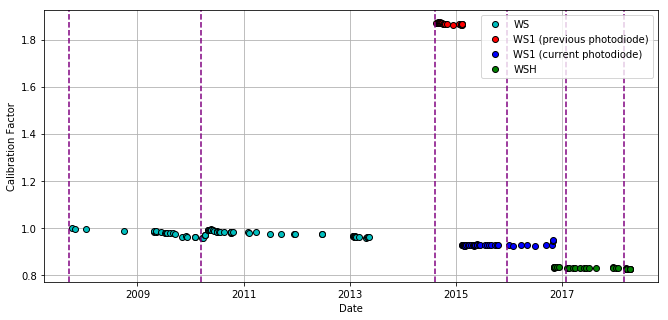

In [401]:
plt.figure(figsize=(11, 5))
plt.plot(WS_GS_dates, WS_GS_vals, 'co', mec='k', label = "WS")
plt.plot(pwr_dates['WS1_GS_pd1'], pwr_vals['WS1_GS_pd1'], 'ro', mec = 'k', label = "WS1 (previous photodiode)")
plt.plot(pwr_dates['WS1_GS'], pwr_vals['WS1_GS'], 'bo', mec = 'k', label = "WS1 (current photodiode)")
plt.plot(pwr_dates['WSH_GS'], pwr_vals['WSH_GS'], 'go', mec = 'k', label = "WSH")
plt.plot(WSH_GS_check_dates, WSH_GS_check, marker='o',color = 'green', mec='k', linestyle='')
plt.legend(loc='upper right', borderaxespad=0.5)
plt.ylabel('Calibration Factor')
plt.xlabel('Date')
plt.grid()
for i in NIST_dates:
    if i == NIST_dates[0]:
        plt.axvline(i, linestyle = '--', color = 'purple', label = "NIST shipments")
    else:
        plt.axvline(i, linestyle = '--', color = 'purple')
# plt.savefig('cal_plot_1.png')
plt.show()

Ratios between each data set are taken in order to scale NIST measurements later in the notebook, as well as to quantify the impact of different changes to the Working Standard/Gold Standard system. 1 corresponds to WS_GS, 4 to WSH_GS.

In [402]:
rat12 = np.mean(WS_GS_vals)/np.mean(pwr_vals['WS1_GS_pd1'])
rat13 = np.mean(WS_GS_vals)/np.mean(pwr_vals['WS1_GS'][0:-2])
rat14 = np.mean(WS_GS_vals)/np.mean(pwr_vals['WSH_GS'])
rat23 = np.mean(pwr_vals['WS1_GS_pd1'])/np.mean(pwr_vals['WS1_GS'][0:-2])
rat24 = np.mean(pwr_vals['WS1_GS_pd1'])/np.mean(pwr_vals['WSH_GS'])
rat34 = np.mean(pwr_vals['WS1_GS'][0:-2])/np.mean(pwr_vals['WSH_GS'])

Ratios and dataset means are diplayed in table below, with the column header as the numerator and row header as the denominator.

|                  |$\textbf{WS}$|$\textbf{WS1_pd1}$|$\textbf{WS1}$|$\textbf{WSH}$|
|------------------|-------------|------------------|--------------|--------------|
|$\textbf{WS}$     |1            |1.91231           |0.94854       |0.85128       |
|$\textbf{WS1_pd1}$|0.52293      |1                 |0.49602       |0.44516       |
|$\textbf{WS1}$    |1.05424      |2.01604           |1             |0.89746       |
|$\textbf{WSH }$   |1.17469      |2.24637           |1.11425       |1             |

Before scaling the measurements, the individual datasets are normalized to their means so their point spreads can be compared over time. Offset WSH_GS measurements are normalized to the mean of previous WSH_GS values.

In [405]:
temp_mean = np.mean(WS_GS_vals)
WS_GS_vals[:] = [100*((x/temp_mean)-1) for x in WS_GS_vals]

temp_mean = np.mean(pwr_vals['WS1_GS_pd1'])
pwr_vals['WS1_GS_pd1'][:] = [100*((x/temp_mean)-1) for x in pwr_vals['WS1_GS_pd1']]

temp_mean = np.mean(pwr_vals['WS1_GS'][:-2])
pwr_vals['WS1_GS'][:] = [100*((x/temp_mean)-1) for x in pwr_vals['WS1_GS']]

temp_mean = np.mean(pwr_vals['WSH_GS'])
pwr_vals['WSH_GS'][:] = [100*((x/temp_mean)-1) for x in pwr_vals['WSH_GS']]
WSH_GS_check[:] = [100*((x/temp_mean)-1) for x in WSH_GS_check]

Starting with WS_GS measurements:

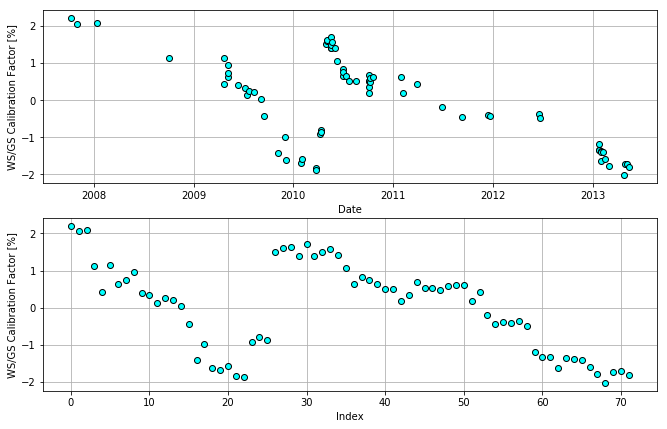

Normalized Standard Deviation: 1.1758916280868033%


In [406]:
plt.figure(figsize=(11,7))
plt.subplot(2,1,1)
plt.plot(WS_GS_dates, WS_GS_vals, color = 'cyan', marker = 'o', linestyle='', mec='k')
plt.grid()
plt.xlabel('Date')
plt.ylabel('WS/GS Calibration Factor [%]')

plt.subplot(2,1,2)
plt.plot(WS_GS_vals, marker = 'o', linestyle = '', color = 'cyan', mec = 'k')
plt.grid()
plt.xlabel('Index')
plt.ylabel('WS/GS Calibration Factor [%]')
# plt.savefig('cal_plot_2.png')
plt.show()

print ('Normalized Standard Deviation: '+str(np.std(WS_GS_vals))+'%')

Moving to the WS1_GS_pd1 measurements. These were taken after the photodiode in the Gold Standard was replaced by NIST.

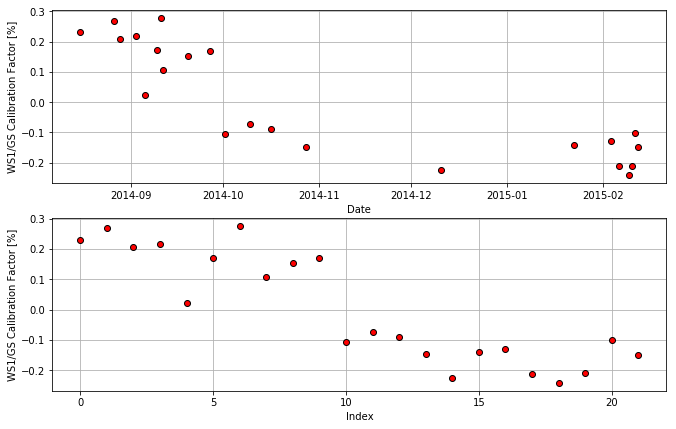

Normalized Standard Deviation: 0.1783651219523441%


In [407]:
plt.figure(figsize=(11,7))
plt.subplot(2,1,1)
plt.plot(pwr_dates['WS1_GS_pd1'], pwr_vals['WS1_GS_pd1'], 'ro', mec = 'k')
plt.grid()
plt.xlabel('Date')
plt.ylabel('WS1/GS Calibration Factor [%]')

plt.subplot(2,1,2)
plt.plot(pwr_vals['WS1_GS_pd1'], color = 'red', mec = 'k', marker = 'o', linestyle = '')
plt.grid()
plt.xlabel('Index')
plt.ylabel('WS1/GS Calibration Factor [%]')
# plt.savefig('cal_plot_3.png')
plt.show()

print ('Normalized Standard Deviation: '+str(np.std(pwr_vals['WS1_GS_pd1']))+'%')

Then the WS1_GS measurement set. This is after the photodiode in WS1 was replaced to match the Gold Standard. The two values at the end of the measurement were taken after the Working Standard was damaged, and are removed from the dataset.

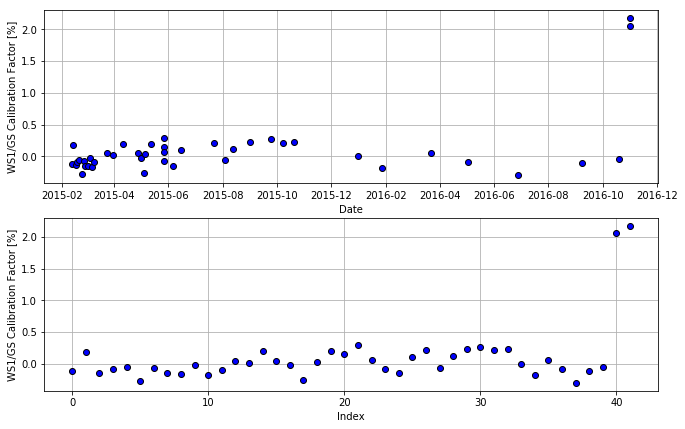

Normalized Standard Deviation: 0.1567482860622688%


In [408]:
plt.figure(figsize=(11,7))
plt.subplot(2,1,1)
plt.plot(pwr_dates['WS1_GS'], pwr_vals['WS1_GS'], 'bo', mec = 'k')
plt.grid()
plt.xlabel('Date')
plt.ylabel('WS1/GS Calibration Factor [%]')

plt.subplot(2,1,2)
plt.plot(pwr_vals['WS1_GS'], color = 'blue', mec = 'k', marker = 'o', linestyle = '')
plt.grid()
plt.xlabel('Index')
plt.ylabel('WS1/GS Calibration Factor [%]')
# plt.savefig('cal_plot_4.png')
plt.show()

print ('Normalized Standard Deviation: '+str(np.std(pwr_vals['WS1_GS'][0:-2]))+'%')
#removing erroneous end measurements
for i in range(2):
    del pwr_vals['WS1_GS'][-1]
    del pwr_dates['WS1_GS'][-1]

Last is the set of measurements using WS3, now termed WSH. The last set of 12 measurements was taken in quick succession over a two day period. The offset and spread of the values is currently being investigated, and the standard deviation is given for the measurements previous to the offset occurrence.

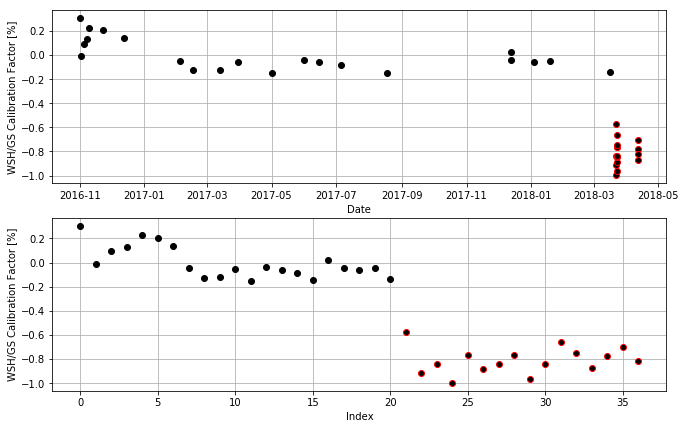

Normalized Standard Deviation: 0.12939219852037%


In [409]:
dummy_index = np.arange(len(pwr_vals['WSH_GS']), len(WSH_GS_check)+len(pwr_vals['WSH_GS']))

plt.figure(figsize=(11,7))
plt.subplot(2,1,1)
plt.plot(pwr_dates['WSH_GS'], pwr_vals['WSH_GS'], 'ko')
plt.plot(WSH_GS_check_dates, WSH_GS_check, 'ko', mec = 'r')
plt.grid()
plt.xlabel('Date')
plt.ylabel('WSH/GS Calibration Factor [%]')

plt.subplot(2,1,2)
plt.plot(pwr_vals['WSH_GS'], marker = 'o', linestyle="", color = 'black')
plt.plot(dummy_index, WSH_GS_check, marker = 'o', linestyle="", color = 'black', mec = 'red')
plt.grid()
plt.ylabel('WSH/GS Calibration Factor [%]')
plt.xlabel('Index')
# plt.savefig('cal_plot_5.png')
plt.show()

print ('Normalized Standard Deviation: '+str(np.std(pwr_vals['WSH_GS']))+'%')

These measurements are scaled to each other by multiplying each set by the ratio of the first value of the reference set to the last value in the set being scaled. This done from right to left.

In [410]:
#Taking out of percent values and centering datasets around 1
WS_GS_vals = (WS_GS_vals/100)+1
pwr_vals['WS1_GS_pd1'][:] = [(x/100)+1 for x in pwr_vals['WS1_GS_pd1']]
pwr_vals['WS1_GS'][:] = [(x/100)+1 for x in pwr_vals['WS1_GS']]
pwr_vals['WSH_GS'][:]  = [(x/100)+1 for x in pwr_vals['WSH_GS']]
WSH_GS_check[:] = [(x/100)+1 for x in WSH_GS_check]

#scaling datasets to each other
pwr_vals['WS1_GS'][:] = [x * (pwr_vals['WSH_GS'][0]/pwr_vals['WS1_GS'][-1]) for x in pwr_vals['WS1_GS']]
pwr_vals['WS1_GS_pd1'][:] = [x * (pwr_vals['WS1_GS'][0]/pwr_vals['WS1_GS_pd1'][-1]) for x in pwr_vals['WS1_GS_pd1']]
WS_GS_vals[:] = [x * (pwr_vals['WS1_GS_pd1'][0]/WS_GS_vals[-1]) for x in WS_GS_vals]

#recentering around 0 and putting back into percent values
WS_GS_vals = 100*(WS_GS_vals-1)
pwr_vals['WS1_GS_pd1'][:] = [100*(x-1) for x in pwr_vals['WS1_GS_pd1']]
pwr_vals['WS1_GS'][:] = [100*(x-1) for x in pwr_vals['WS1_GS']]
pwr_vals['WSH_GS'][:]  = [100*(x-1) for x in pwr_vals['WSH_GS']]
WSH_GS_check[:] = [100*(x-1) for x in WSH_GS_check]

The normalized and scaled plot is shown below:

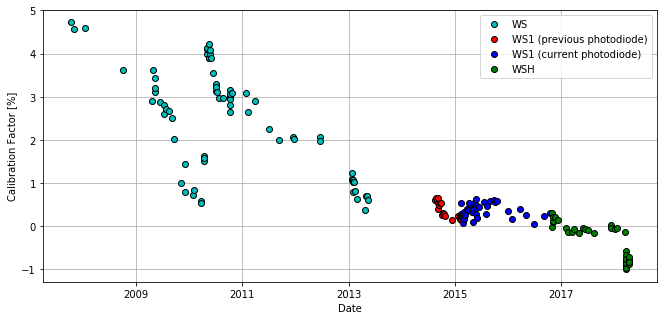

In [411]:
plt.figure(figsize=(11, 5))
plt.plot(WS_GS_dates, WS_GS_vals, 'co', mec='k', label = "WS")
plt.plot(pwr_dates['WS1_GS_pd1'], pwr_vals['WS1_GS_pd1'], 'ro', mec = 'k', label = "WS1 (previous photodiode)")
plt.plot(pwr_dates['WS1_GS'], pwr_vals['WS1_GS'], 'bo', mec = 'k', label = "WS1 (current photodiode)")
plt.plot(pwr_dates['WSH_GS'], pwr_vals['WSH_GS'], 'go', mec = 'k', label = "WSH")
plt.plot(WSH_GS_check_dates, WSH_GS_check, marker='o',color = 'green', mec='k', linestyle='')
plt.ylabel('Calibration Factor [%]')
plt.xlabel('Date')
plt.legend()
plt.grid()
# plt.savefig('cal_plot_6.png')
plt.show()

NIST calibration factors are examined to compare Working Standard measurement spread to the spread of NIST measurements. The NIST measurements (upper plot shown below), show distinct changes between the first two and second two measurements. The exact cause of these changes is still being investigated, though the jump between the second and third is likely caused by a photodiode change in the Gold Standard.

In the lower plot the initial NIST values are scaled by changing the sign and then multipyling by the scaling factors obtained earlier in the notebook.

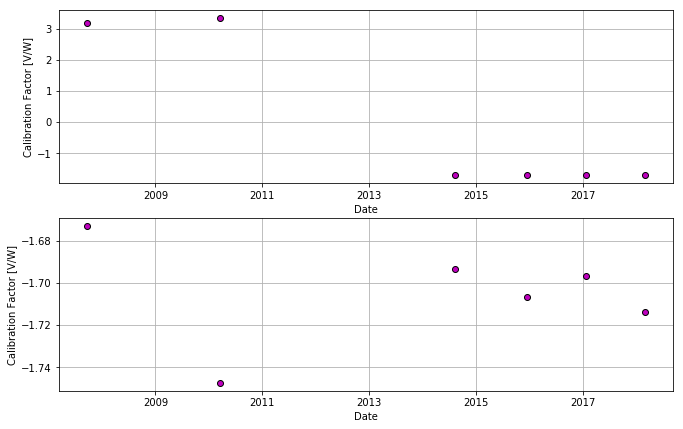

In [412]:
plt.figure(figsize=(11,7))
plt.subplot(211)
plt.plot(NIST_dates, NIST, 'mo', mec='k')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Calibration Factor [V/W]')

NIST[0:2] = [x*-rat12 for x in NIST[0:2]]

plt.subplot(212)
plt.plot(NIST_dates, NIST, 'mo', mec='k')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Calibration Factor [V/W]')
# plt.savefig('cal_plot_7.png')
plt.show()

### Experimental Measurements

The next section focuses on potential sources of error in our power sensor calibrating methods, and the results of exploring these sources.

The source of the WSH_GS offset is first to be investigated. WSL_GS values were taken over a one day period to determine if the Gold Standard was the source of error in the WSH_GS measurements. The values were found to be in line with the previous measurements, with an offset far lower than that between old and new WSH_GS measurements. The standard in error would then appear to be WSH.

WSL_GS values are shown below, with red-outlined points being the set of recent measurements.

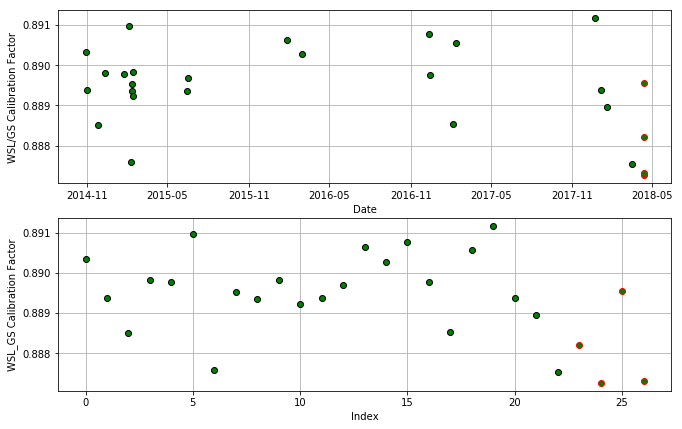

In [413]:
dummy_index = np.arange(len(pwr_vals['WSL_GS']), len(WSL_GS_check)+len(pwr_vals['WSL_GS']))

plt.figure(figsize=(11,7))
plt.subplot(211)
plt.plot(pwr_dates['WSL_GS'], pwr_vals['WSL_GS'], 'go', mec='k')
plt.plot(WSL_GS_check_dates, WSL_GS_check, 'go', mec='r')
plt.grid()
plt.ylabel('WSL/GS Calibration Factor')
plt.xlabel('Date')

plt.subplot(212)
plt.plot(pwr_vals['WSL_GS'], color = 'green', marker = 'o', linestyle = '', mec='k')
plt.plot(dummy_index, WSL_GS_check, 'go', mec='r')
plt.grid()
plt.xlabel('Index')
plt.ylabel('WSL_GS Calibration Factor')
# plt.savefig('cal_plot_8.png')
plt.show()

Possible degradation of the back lining of WSH was then investigated. The degradation was thought to have potentially been caused by the use of integrating sphere mounts, which constrain the distance between the beam splitter and the sphere, as well as the angle of incidence into the sphere aperture.

A set of seven measurements was taken with the mounts removed, allowing for more variation in angle and distance from beam splitter. The results held similar offset and spread, indicating that the back lining of the integrating sphere is not the source of error.

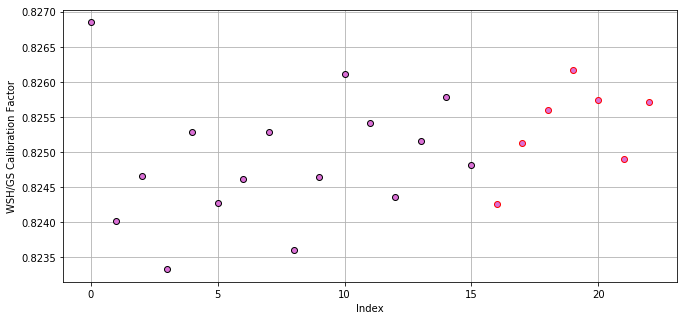

In [414]:
dummy_index = np.arange(len(WSH_GS_check1), len(mountless_cal)+len(WSH_GS_check1))

plt.figure(figsize = (11,5))
plt.plot(WSH_GS_check1, color = 'orchid', marker='o', linestyle='', mec='k')
plt.plot(dummy_index, mountless_cal, color='orchid', marker='o', linestyle='', mec='r')
plt.grid()
plt.xlabel('Index')
plt.ylabel('WSH/GS Calibration Factor')
# plt.savefig('cal_plot_9.png')
plt.show()

With evidence of WSH being the source of the offset, we can use current WSH/GS and WSL/GS values to predict WSH/WSL values to be taken in the future.

In [415]:
WSH_recent = np.append(WSH_GS_check1, mountless_cal)
WSL_tot = np.append(pwr_vals['WSL_GS'], WSL_GS_check)

print (np.mean(WSL_tot)/np.mean(WSH_recent))

1.0779937866761917


The beam splitter is then inspected as a source of temperature-dependent error. The concern was that the beam splitter was in some measurements covered by a beam dump for the hour that the laser stabilized and in some heated up with the laser for that hour. 

To test this, the beam splitter was covered for the hour that the laser stabilized, and then an hour long WSH/GS integration was taken to look for temperature-dependent variations. The data (plotted below) shows that any monotonic properties of the beam splitter heating up are small compared to laser speckle variation. Data measurements are taken twice per second.

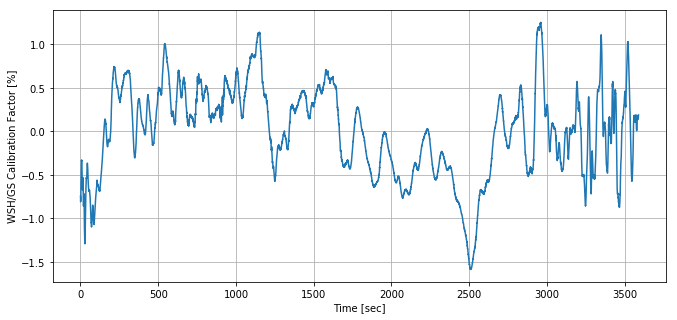

In [416]:
time_index = np.arange(len(WStrans_tempcheck))*0.5
temp_ratio = WStrans_tempcheck/GSrefl_tempcheck
temp_ratio = (100*(temp_ratio/np.mean(temp_ratio)-1))
plt.figure(figsize=(11,5))
plt.plot(time_index, temp_ratio)
plt.grid()
plt.ylabel('WSH/GS Calibration Factor [%]')
plt.xlabel('Time [sec]')
# plt.savefig('cal_plot_10.png')
plt.show()